In [1]:
import pyjuice as juice
import torch
# import torchvision
import time
from torch.utils.data import TensorDataset, DataLoader
import pyjuice.nodes.distributions as dists
import numpy as np
import pandas as pd

import seaborn as sns
import pandas as pd
import numpy as np
import importlib
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

import sys
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from bed_reader import open_bed
import gc


In [2]:
G = open_bed('data/fourier_ls-chr6-1167_train.bed')
train_geno = G.read(index=np.s_[:, :])

print(train_geno.shape)

G = open_bed('data/fourier_ls-chr6-1167_test.bed')
test_geno = G.read(index=np.s_[:, :])

print(test_geno.shape)

device = torch.device("cuda:0")
np.random.seed(1)

data_dir = "data1kg"
file_name = "10K.data"

def load(file_name, data_dir):
    filename = f"{data_dir}/{file_name}"
    dataframe = pd.read_csv(filename, header=None,
                            true_values=["1", "2", "3"],
                            false_values=["0"], dtype=object)
    data = dataframe.iloc[:, 0].str.split(' ')
    return np.array([np.array(entry) for entry in data])

# data = load(file_name, data_dir)
# data = data.astype(np.int8)
train_data = train_geno.astype(np.int8)
valid_data = test_geno.astype(np.int8)
# print(data.shape)

# total_size = len(data)

# train_size = int(0.8 * total_size)
# valid_size = int(0.1 * total_size)
# test_size = total_size - train_size - valid_size

# indices = np.random.permutation(total_size)

# train_indices = indices[:train_size]
# valid_indices = indices[train_size:train_size + valid_size]
# test_indices = indices[train_size + valid_size:]

# train_data = data[train_indices]
# valid_data = data[valid_indices]
# test_data = data[test_indices]

train_data = torch.tensor(train_data, dtype=torch.long)
valid_data = torch.tensor(valid_data, dtype=torch.long)
# test_data = torch.tensor(test_data, dtype=torch.long)

print(train_data.shape)
print(valid_data.shape)
# print(test_data.shape)

train_loader = DataLoader(
    dataset = TensorDataset(train_data),
    batch_size = 1024,
    shuffle = True,
    drop_last = True
)
valid_loader = DataLoader(
    dataset = TensorDataset(valid_data),
    batch_size = 1024,
    shuffle = False,
    drop_last = True
)

(225245, 1167)
(56312, 1167)
torch.Size([225245, 1167])
torch.Size([56312, 1167])


In [16]:
maf_list = []
for snp in range(data.shape[1]):
    # For each SNP (column), get the counts of 0, 1, 2
    snp_data = data[:, snp]
    
    # Count number of occurrences of 0, 1, and 2
    num_0 = np.sum(snp_data == 0)  # Homozygous major
    num_1 = np.sum(snp_data == 1)  # Heterozygous
    num_2 = np.sum(snp_data == 2)  # Homozygous minor

    # Total number of alleles
    total_alleles = 2 * data.shape[0]

    # Number of minor alleles (1 heterozygous = 1 minor, 1 homozygous minor = 2 minor)
    num_minor_alleles = num_1 + 2 * num_2

    # Calculate MAF
    maf = num_minor_alleles / total_alleles
    maf_list.append(maf)

# Store MAFs in a file
maf_array = np.array(maf_list)

np.savetxt("chr6-1167.maf.txt", maf_array, fmt="%.5f", header="", comments="")

In [5]:
# The data is required to construct the backbone Chow-Liu Tree structure for the HCLT
ns = juice.structures.HCLT(
    train_data.float().to(device),
    num_latents = 16,
    input_dist=dists.Categorical(num_cats=3)
)

pc = juice.compile(ns)
pc.to(device)

num_epochs = 400

optimizer = juice.optim.CircuitOptimizer(pc, lr = 0.05, pseudocount = 0.005, method = "EM")
scheduler = juice.optim.CircuitScheduler(
    optimizer,
    method = "multi_linear",
    lrs = [0.05, 0.01],
    milestone_steps = [0, len(train_loader) * num_epochs]
)

Compiling 50 TensorCircuit layers...


100%|██████████| 50/50 [00:06<00:00,  8.17it/s]


In [6]:
for batch in train_loader:
    x = batch[0].to(device)

    lls = pc(x, record_cudagraph = True)
    lls.mean().backward()
    break

In [31]:
for epoch in range(1, num_epochs+1):
    t0 = time.time()
    train_ll = 0.0
    for batch in train_loader:
        x = batch[0].to(device)

        # Similar to PyTorch optimizers zeroling out the gradients, we zero out the parameter flows
        optimizer.zero_grad()

        # Forward pass
        lls = pc(x)

        # Backward pass
        lls.mean().backward()

        train_ll += lls.mean().detach().cpu().numpy().item()

        # Perform a mini-batch EM step
        optimizer.step()
        scheduler.step()

    train_ll /= len(train_loader)

    t1 = time.time()
    test_ll = 0.0
    for batch in valid_loader:
        x = batch[0].to(pc.device)
        lls = pc(x)
        test_ll += lls.mean().detach().cpu().numpy().item()

    test_ll /= len(valid_loader)
    t2 = time.time()

    print(f"[Epoch {epoch}/{num_epochs}][train LL: {train_ll:.2f}; val LL: {test_ll:.2f}].....[train forward+backward+step {t1-t0:.2f}; val forward {t2-t1:.2f}] ")

[Epoch 1/400][train LL: -386.24; val LL: -393.09].....[train forward+backward+step 0.05; val forward 0.00] 
[Epoch 2/400][train LL: -386.41; val LL: -393.09].....[train forward+backward+step 0.03; val forward 0.00] 
[Epoch 3/400][train LL: -386.26; val LL: -393.09].....[train forward+backward+step 0.03; val forward 0.00] 
[Epoch 4/400][train LL: -386.36; val LL: -393.09].....[train forward+backward+step 0.03; val forward 0.00] 
[Epoch 5/400][train LL: -386.34; val LL: -393.09].....[train forward+backward+step 0.03; val forward 0.00] 
[Epoch 6/400][train LL: -386.36; val LL: -393.09].....[train forward+backward+step 0.03; val forward 0.00] 
[Epoch 7/400][train LL: -386.24; val LL: -393.08].....[train forward+backward+step 0.03; val forward 0.00] 
[Epoch 8/400][train LL: -386.44; val LL: -393.09].....[train forward+backward+step 0.03; val forward 0.00] 
[Epoch 9/400][train LL: -386.26; val LL: -393.09].....[train forward+backward+step 0.03; val forward 0.00] 
[Epoch 10/400][train LL: -38

In [7]:
for epoch in range(1, num_epochs+1):
    t0 = time.time()

    # Manually zeroling out the flows
    pc.init_param_flows(flows_memory = 0.0)

    train_ll = 0.0
    for batch in train_loader:
        x = batch[0].to(device)

        # We only run the forward and the backward pass, and accumulate the flows throughout the epoch
        lls = pc(x)
        lls.mean().backward()

        train_ll += lls.mean().detach().cpu().numpy().item()

    # Set step size to 1.0 for full-batch EM
    pc.mini_batch_em(step_size = 1.0, pseudocount = 0.005)

    train_ll /= len(train_loader)

    t1 = time.time()
    test_ll = 0.0
    for batch in valid_loader:
        x = batch[0].to(pc.device)
        lls = pc(x)
        test_ll += lls.mean().detach().cpu().numpy().item()

    test_ll /= len(valid_loader)
    t2 = time.time()
    print(f"[Epoch {epoch}/{num_epochs}][train LL: {train_ll:.2f}; val LL: {test_ll:.2f}].....[train forward+backward+step {t1-t0:.2f}; val forward {t2-t1:.2f}] ")

[Epoch 1/400][train LL: -1317.48; val LL: -338.84].....[train forward+backward+step 3.17; val forward 0.21] 
[Epoch 2/400][train LL: -338.62; val LL: -186.94].....[train forward+backward+step 2.70; val forward 0.17] 
[Epoch 3/400][train LL: -186.59; val LL: -143.89].....[train forward+backward+step 3.56; val forward 0.27] 
[Epoch 4/400][train LL: -143.49; val LL: -132.72].....[train forward+backward+step 2.84; val forward 0.31] 
[Epoch 5/400][train LL: -132.32; val LL: -128.20].....[train forward+backward+step 2.96; val forward 0.16] 
[Epoch 6/400][train LL: -127.80; val LL: -125.22].....[train forward+backward+step 3.66; val forward 0.30] 
[Epoch 7/400][train LL: -124.82; val LL: -122.72].....[train forward+backward+step 2.84; val forward 0.41] 
[Epoch 8/400][train LL: -122.32; val LL: -120.59].....[train forward+backward+step 3.33; val forward 0.15] 
[Epoch 9/400][train LL: -120.18; val LL: -118.75].....[train forward+backward+step 2.74; val forward 0.28] 
[Epoch 10/400][train LL: -1

KeyboardInterrupt: 

In [48]:
juice.save('circuit_805.jpc', ns)

In [49]:
juice.save('test_805.jpc', pc)

In [21]:
device = torch.device("cuda:0")
ns = juice.load('circuits/pc_chr6-1167-16.jpc')
pc = juice.compile(ns)
pc.to(device)

Compiling 52 TensorCircuit layers...


100%|██████████| 52/52 [00:04<00:00, 11.00it/s]


TensorCircuit(
  (input_layer_group): LayerGroup(
    (layer_0): InputLayer()
  )
  (prod_layer_0): LayerGroup(
    (layer_0): ProdLayer(
      (partitioned_nids): FastParamList(
          (0): Parameter containing: [torch.int64 of size 124 (cuda:0)]
          (1): Parameter containing: [torch.int64 of size 12 (cuda:0)]
      )
      (partitioned_cids): FastParamList(
          (0): Parameter containing: [torch.int64 of size 124x4 (cuda:0)]
          (1): Parameter containing: [torch.int64 of size 12x8 (cuda:0)]
      )
      (partitioned_u_cids): FastParamList(  (0): Parameter containing: [torch.int64 of size 362 (cuda:0)])
      (partitioned_parids): FastParamList(  (0): Parameter containing: [torch.int64 of size 362x1 (cuda:0)])
    )
  )
  (sum_layer_0): LayerGroup(
    (layer_0): SumLayer(
      (partitioned_nids): FastParamList(  (0): Parameter containing: [torch.int64 of size 136 (cuda:0)])
      (partitioned_cids): FastParamList(  (0): Parameter containing: [torch.int64 of size

In [4]:
samples = juice.queries.sample(pc, num_samples = 5008)
print(samples.shape)

torch.Size([5008, 1167])


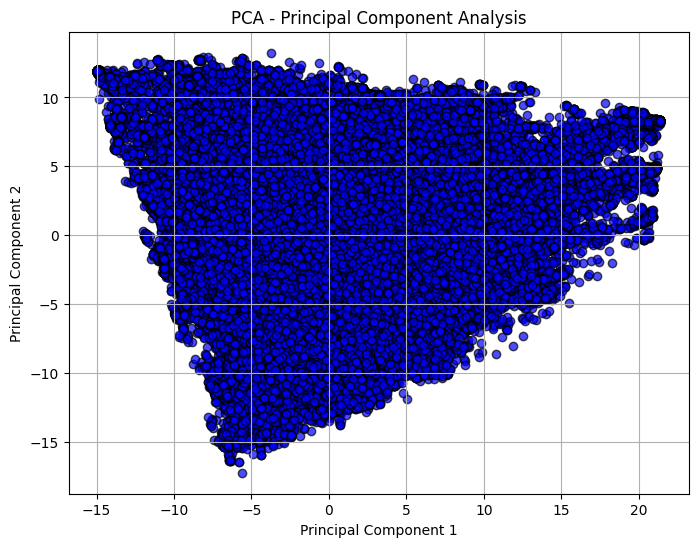

In [7]:
# Initialize PCA
data = torch.tensor(data, dtype=torch.long)
data = data.cpu()

pca = PCA(n_components=2)

pca.fit(data)
# Fit and transform the data
pcs = pca.transform(data)

# pcs now contains the principal components
# pcs[:, 0] are the x-coordinates (PC1)
# pcs[:, 1] are the y-coordinates (PC2)

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(pcs[:, 0], pcs[:, 1], c='blue', edgecolor='k', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - Principal Component Analysis')
plt.grid(True)
plt.show()

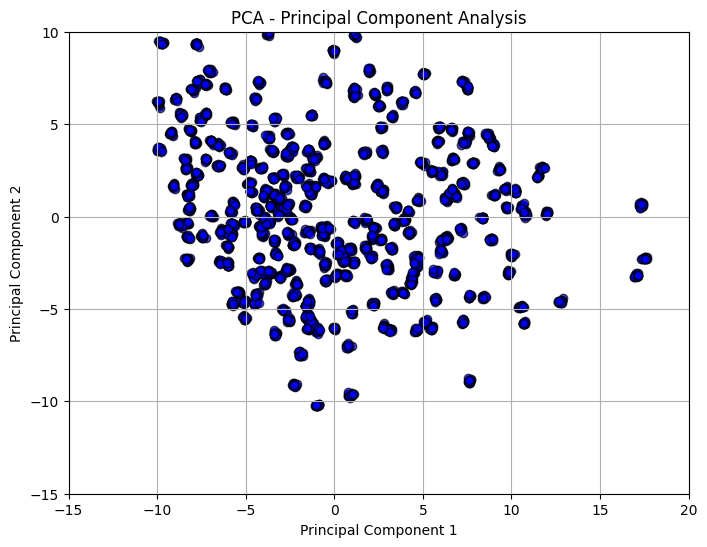

In [8]:
# Initialize PCA
pca = PCA(n_components=2)

pca.fit(data)

samples_cpu = samples.cpu()

# Fit and transform the data
# pcs1 = pca.transform(data)
pcs = pca.transform(samples_cpu)

# pcs now contains the principal components
# pcs[:, 0] are the x-coordinates (PC1)
# pcs[:, 1] are the y-coordinates (PC2)

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(pcs[:, 0], pcs[:, 1], c='blue', edgecolor='k', alpha=0.7)

# plt.scatter(pcs1[:, 0], pcs1[:, 1], c='orange', edgecolor='k', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - Principal Component Analysis')

if data.shape[1] > 805:
    plt.xlim(-15, 20)  # Match the x-axis range from the first plot
    plt.ylim(-15, 10)   # Match the y-axis range from the first plot
else:
    plt.xlim(-6, 10)
    plt.ylim(-6, 6.5)

plt.grid(True)
plt.show()

In [14]:
e = [1.2965e-01, 6.6344e-04, 3.8661e-06]
probs = e / np.sum(e)
print(probs)

[9.94879375e-01 5.09095852e-03 2.96668195e-05]


In [23]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 8192
dataset = TensorDataset(valid_data)
dataloader = DataLoader(dataset, batch_size=batch_size)

num_samples = valid_data.size(0)
num_features = valid_data.size(1)

sse_acc = np.zeros(num_features)
sst_acc = np.zeros(num_features)

pseudolikelihoods = np.zeros(num_samples)

means = torch.mean(valid_data.float(), dim=0).to(device)

i = 1
batch_start = 0
for batch in dataloader:
    print(f'Batch {i}')
    data = batch[0].to(device)
    batch_size = data.size(0)

    batch_end = batch_start + batch_size

    for pos in range(num_features):
        print(pos)
        false_array = torch.full((num_features,), False, dtype=torch.bool).to(device)
        false_array[pos] = True
        missing_mask = torch.tensor(false_array).to(device)

        lls = juice.queries.conditional(pc, data=data, missing_mask=missing_mask)
        probs = lls[:, pos:pos+1, :]

        original = data[:, pos]

        # false_array = torch.full((num_features,), False, dtype=torch.bool).to(device)
        # missing_mask = torch.tensor(false_array).to(device)

        # data0 = data.clone()
        # data0[:, pos] = 0
        # lls0 = juice.queries.marginal(pc, data=data0, missing_mask=missing_mask)
        # print(lls0)

        # data1 = data.clone()
        # data1[:, pos] = 1
        # lls1 = juice.queries.marginal(pc, data=data1, missing_mask=missing_mask)
        # print(lls1)

        # data2 = data.clone()
        # data2[:, pos] = 2
        # lls2 = juice.queries.marginal(pc, data=data2, missing_mask=missing_mask)
        # print(lls2)

        # lls_stack = torch.stack([lls0, lls1, lls2], dim=-1)

        # print(lls_stack)

        max_probs, predictions = torch.max(probs, dim=-1)
        predictions = predictions.T.squeeze()

        correct_probs = torch.gather(probs.squeeze(1), 1, original.unsqueeze(1)).squeeze()
        log_correct_probs = torch.log(correct_probs)

        pseudolikelihoods[batch_start:batch_end] += log_correct_probs.cpu().numpy()

        # Calculate the sum of squared errors (SSE) for the current batch
        sse_batch = torch.sum((original - predictions) ** 2).item()

        # Calculate the total sum of squares (SST) for the current batch
        sst_batch = torch.sum((original - means[pos]) ** 2).item()

        # Accumulate SSE and SST for the current feature
        sse_acc[pos] += sse_batch
        sst_acc[pos] += sst_batch
    
    batch_start = batch_end
    i += 1
    
# After processing all batches, calculate R^2 for each feature

r2s = 1 - (sse_acc / sst_acc)

print("R2 scores:", r2s)
print("Pseudolikelihoods:", pseudolikelihoods)

# np.savetxt('results/r2s_chr6-1167-512', r2s)

0
R2 scores: [0.11593569        nan        nan ...        nan        nan        nan]
Accumulated log sums: [-336.16171265    0.            0.         ...    0.            0.
    0.        ]


/tmp/ipykernel_1014633/4124642257.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  missing_mask = torch.tensor(false_array).to(device)
/tmp/ipykernel_1014633/4124642257.py:77: RuntimeWarning: invalid value encountered in divide
  r2s = 1 - (sse_acc / sst_acc)


In [3]:
r2s_16 = np.loadtxt('results/r2s_chr6-1167-16')
r2s_128 = np.loadtxt('results/r2s_chr6-1167-128')
r2s_512 = np.loadtxt('results/r2s_chr6-1167-512')
r2s_1024 = np.loadtxt('results/r2s_chr6-1167-1024')
r2s_impute5 = np.loadtxt('results/r2s_chr6-1167_impute5')

pl = np.loadtxt('results/pseudolikelihoods_chr6-1167-1024')
pl_impute5 = np.loadtxt('results/pseudolikelihoods_chr6-1167_impute5')

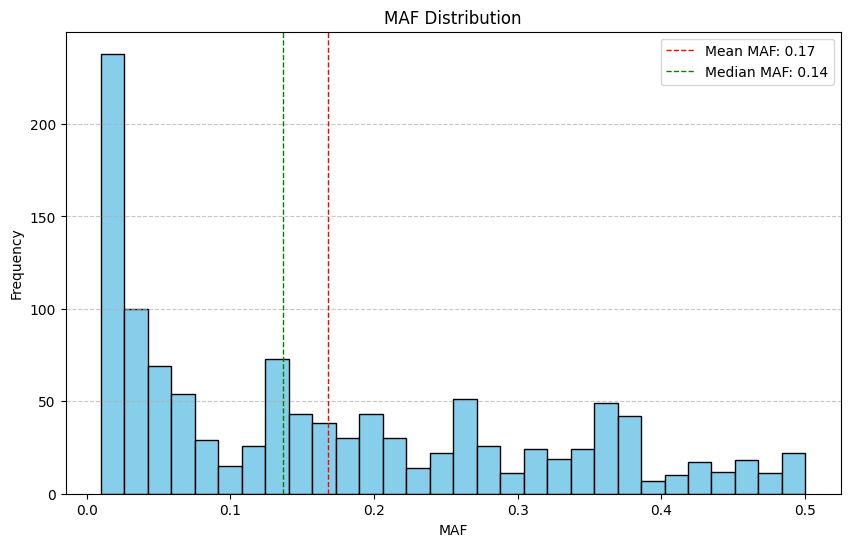

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Load MAF values
with open('results/chr6-1167.maf.txt', 'r') as file:
    maf_values = np.array([float(line.strip()) for line in file])

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(maf_values, bins=30, color='skyblue', edgecolor='black')

# Customize the plot
plt.title("MAF Distribution")
plt.xlabel("MAF")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axvline(np.mean(maf_values), color='red', linestyle='dashed', linewidth=1, label=f'Mean MAF: {np.mean(maf_values):.2f}')
plt.axvline(np.median(maf_values), color='green', linestyle='dashed', linewidth=1, label=f'Median MAF: {np.median(maf_values):.2f}')
plt.legend()

plt.show()


[0.      0.12005 0.2401  0.36015 0.4802  0.60025]
[0 0 0 ... 4 4 4]


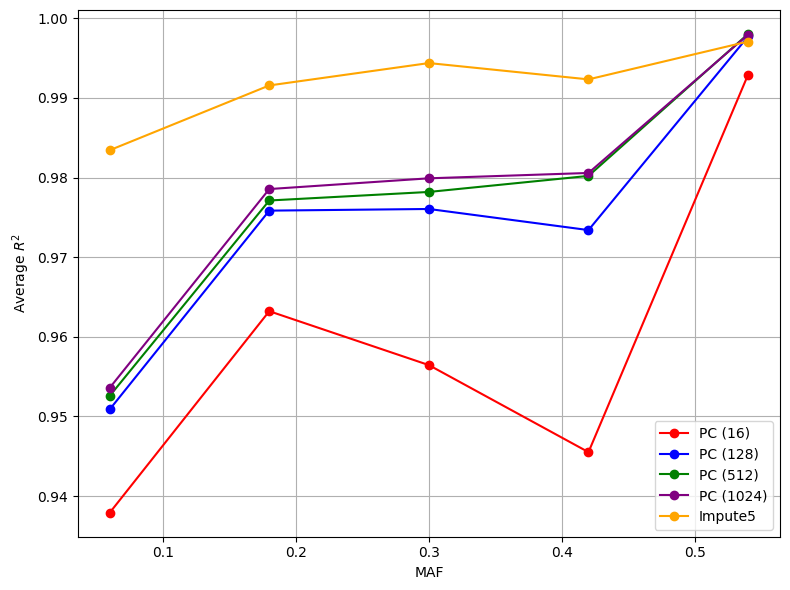

In [5]:
import numpy as np
import matplotlib.pyplot as plt

with open('results/chr6-1167.maf.txt', 'r') as file:
    maf_values = np.array([float(line.strip()) for line in file])

sorted_indices = np.argsort(maf_values)
sorted_maf = maf_values[sorted_indices]
sorted_accuracies = [r2s_16[sorted_indices], r2s_128[sorted_indices], r2s_512[sorted_indices], r2s_1024[sorted_indices], r2s_impute5[sorted_indices]]

num_bins = 5
bins = np.linspace(0, max(maf_values)+0.1, num_bins + 1)
print(bins)
bin_indices = np.digitize(sorted_maf, bins) - 1
print(bin_indices)

# Calculate average accuracies for each method
average_accuracies = []
for acc in sorted_accuracies:
    averages = np.array([acc[bin_indices == i].mean() if np.any(bin_indices == i) else np.nan for i in range(num_bins)])
    average_accuracies.append(averages)

bin_centers = 0.5 * (bins[:-1] + bins[1:])
labels = ['PC (16)', 'PC (128)', 'PC (512)', 'PC (1024)', 'Impute5']
colors = ['r', 'b', 'g', 'purple', 'orange']

plt.figure(figsize=(8, 6))
for avg_acc, label, color in zip(average_accuracies, labels, colors):
    plt.plot(bin_centers, avg_acc, marker='o', linestyle='-', color=color, label=label)

plt.xlabel('MAF')
plt.ylabel(r'Average $R^2$')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

-19.853158832888656
-11.690446882866674
(56312,)
-11.690279763121188
[0.       0.060025 0.12005  0.180075 0.2401   0.300125 0.36015  0.420175
 0.4802   0.540225 0.60025 ]
[0 0 0 ... 8 8 8]


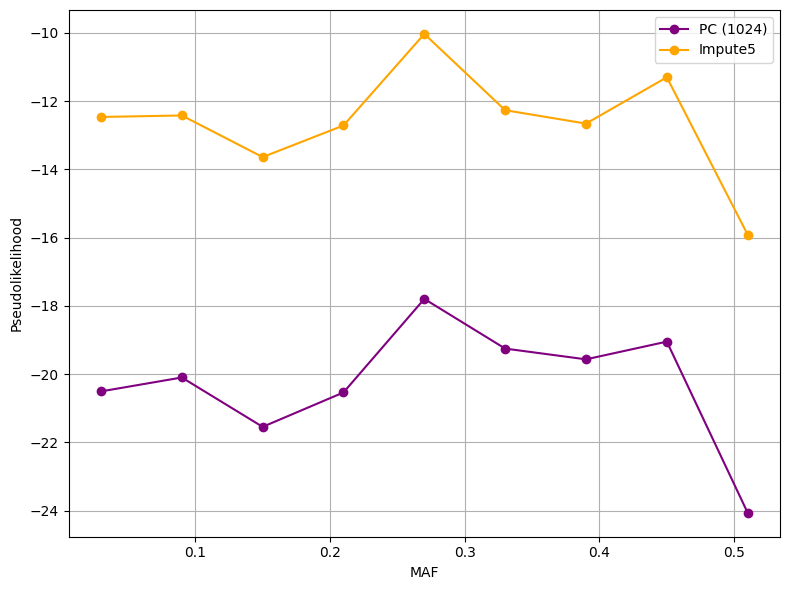

In [6]:
import math

with open('results/chr6-1167.maf.txt', 'r') as file:
    maf_values = np.array([float(line.strip()) for line in file])

print(np.mean(pl))
print(np.mean(pl_impute5))

pl_impute5_filtered = pd.read_csv('results/pseudolikelihoods_filtered_impute5.csv', header=None)
pl_impute5_filtered = pl_impute5_filtered.replace(1.0, math.log(0.00009999))
# pl_impute5_filtered = pl_impute5_filtered[~pl_impute5_filtered.eq(1.0).any(axis=1)]
pl_sum = pl_impute5_filtered.sum(axis=1)
print(pl_sum.shape)
print(np.mean(pl_sum))

sorted_indices = np.argsort(maf_values)
sorted_maf = maf_values[sorted_indices]
sorted_logprobs = [pl[sorted_indices], pl_impute5[sorted_indices]]

num_bins = 10
bins = np.linspace(0, max(maf_values)+0.1, num_bins + 1)
print(bins)
bin_indices = np.digitize(sorted_maf, bins) - 1
print(bin_indices)

# Calculate average accuracies for each method
average_logprobs = []
for acc in sorted_logprobs:
    averages = np.array([acc[bin_indices == i].mean() if np.any(bin_indices == i) else np.nan for i in range(num_bins)])
    average_logprobs.append(averages)

bin_centers = 0.5 * (bins[:-1] + bins[1:])
labels = ['PC (1024)', 'Impute5']
colors = ['purple', 'orange']

plt.figure(figsize=(8, 6))
for avg_prob, label, color in zip(average_logprobs, labels, colors):
    plt.plot(bin_centers, avg_prob, marker='o', linestyle='-', color=color, label=label)

plt.xlabel('MAF')
plt.ylabel('Pseudolikelihood')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

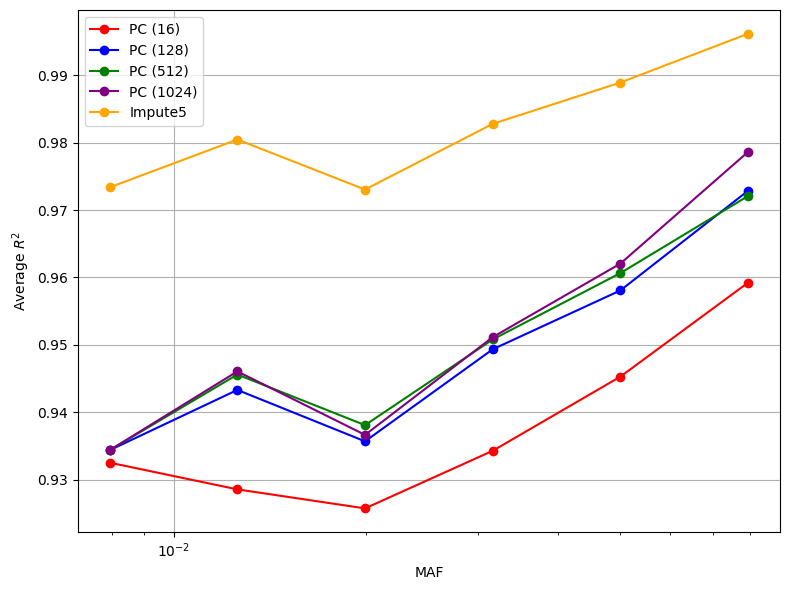

In [7]:
with open('results/chr6-1167.maf.txt', 'r') as file:
    maf_values = np.array([float(line.strip()) for line in file])

sorted_indices = np.argsort(maf_values)
sorted_maf = maf_values[sorted_indices]
sorted_accuracies = [r2s_16[sorted_indices], r2s_128[sorted_indices], r2s_512[sorted_indices], r2s_1024[sorted_indices], r2s_impute5[sorted_indices]]

num_bins = 10
bins = np.logspace(-3, -1, num_bins + 1)
bin_indices = np.digitize(sorted_maf, bins) - 1

# Calculate average accuracies for each method
average_accuracies = []
for acc in sorted_accuracies:
    averages = np.array([acc[bin_indices == i].mean() if np.any(bin_indices == i) else np.nan for i in range(num_bins)])
    average_accuracies.append(averages)

bin_centers = np.sqrt(bins[:-1] * bins[1:])
labels = ['PC (16)', 'PC (128)', 'PC (512)', 'PC (1024)', 'Impute5']
colors = ['r', 'b', 'g', 'purple', 'orange']

plt.figure(figsize=(8, 6))
for avg_acc, label, color in zip(average_accuracies, labels, colors):
    plt.plot(bin_centers, avg_acc, marker='o', linestyle='-', color=color, label=label)

plt.xscale('log')
plt.xlabel('MAF')
plt.ylabel(r'Average $R^2$')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

[0.00983 0.01035 0.0104  ... 0.4917  0.49273 0.50025]
[0.93435831 0.89080883 0.99164238 ... 0.99943284 0.99164006 0.99587858]


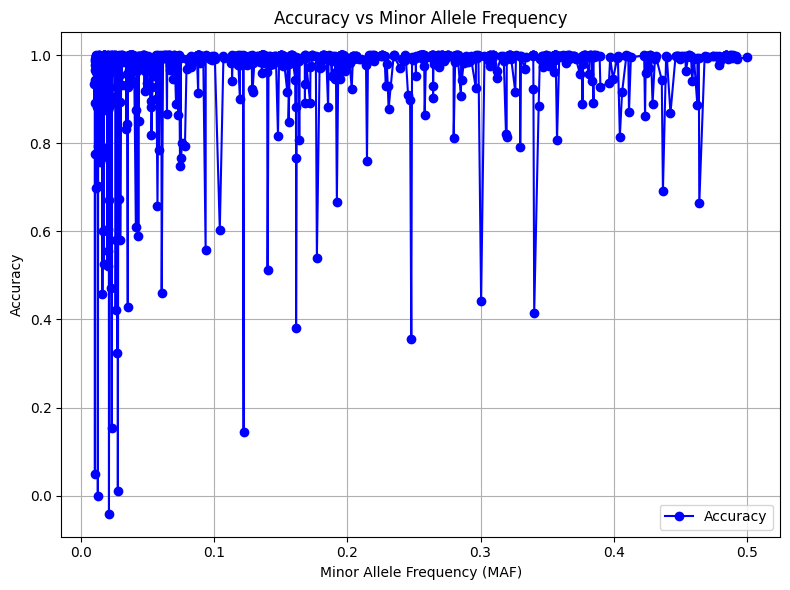

In [16]:
with open('results/chr6-1167.maf.txt', 'r') as file:
    maf_values = np.array([float(line.strip()) for line in file])

sorted_indices = np.argsort(maf_values)
sorted_maf = maf_values[sorted_indices]
sorted_accuracies = r2s_512[sorted_indices]

print(sorted_maf)
print(sorted_accuracies)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(sorted_maf, sorted_accuracies, marker='o', linestyle='-', color='b', label='Accuracy')
plt.xlabel('Minor Allele Frequency (MAF)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Minor Allele Frequency')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [2]:
ni0 = juice.inputs(0, num_nodes = 2, dist = dists.Categorical(num_cats = 2))
ni1 = juice.inputs(1, num_nodes = 2, dist = dists.Categorical(num_cats = 4))

ms = juice.multiply(ni0, ni1)
ns = juice.summate(ms, num_nodes = 1)

ns.init_parameters()

pc = juice.compile(ns)

device = torch.device("cuda:0")
pc.to(device)

Compiling 2 TensorCircuit layers...


100%|██████████| 2/2 [00:00<00:00,  7.95it/s]


TensorCircuit(
  (input_layer_group): LayerGroup(
    (layer_0): InputLayer()
  )
  (prod_layer_0): LayerGroup(
    (layer_0): ProdLayer(
      (partitioned_nids): FastParamList(  (0): Parameter containing: [torch.int64 of size 2 (cuda:0)])
      (partitioned_cids): FastParamList(  (0): Parameter containing: [torch.int64 of size 2x2 (cuda:0)])
      (partitioned_u_cids): FastParamList(  (0): Parameter containing: [torch.int64 of size 4 (cuda:0)])
      (partitioned_parids): FastParamList(  (0): Parameter containing: [torch.int64 of size 4x1 (cuda:0)])
    )
  )
  (sum_layer_0): LayerGroup(
    (layer_0): SumLayer(
      (partitioned_nids): FastParamList(  (0): Parameter containing: [torch.int64 of size 1 (cuda:0)])
      (partitioned_cids): FastParamList(  (0): Parameter containing: [torch.int64 of size 1x2 (cuda:0)])
      (partitioned_pids): FastParamList(  (0): Parameter containing: [torch.int64 of size 1x2 (cuda:0)])
      (partitioned_pfids): FastParamList(  (0): Parameter contain

In [3]:
data = torch.tensor([[0, 0], [1, 0]]).to(device)
missing_mask = torch.tensor([[False, True]]).to(device)

In [6]:
outputs = juice.queries.conditional(
    pc, data = data, missing_mask = missing_mask, target_vars = [1]
)

print(outputs)

outputs = juice.queries.conditional(
    pc, data = data, missing_mask = missing_mask
)

print(outputs[:, 1, :])

tensor([[[0.1053, 0.4940, 0.2592, 0.1415]],

        [[0.1350, 0.3746, 0.3253, 0.1650]]], device='cuda:0')
tensor([[0.1053, 0.4940, 0.2592, 0.1415],
        [0.1350, 0.3746, 0.3253, 0.1650]], device='cuda:0')
